# Train Model for Emotion Recognition

Implementasi Convolutional Neural Network (CNN) menggunakan PyTorch dan ResNet (Residual Network) yang dilatih untuk melakukan pengenalan emosi.

## Installation

In [ ]:
%pip install torch torchvision numpy matplotlib torchsummary torchviz

## Model Initialization with CNN Pytorch

**CNN** adalah jenis Deep Learning model yang sangat efektif untuk tugas yang berhubungan dengan pengolahan gambar. [**PyTorch**](https://pytorch.org/) adalah programming environment _open-source_ berbasis Python yang dikembangkan oleh Facebook, yang memfasilitasi penelitian dan produksi dalam bidang machine learning

![cnn.png](./assets/images/cnn-visualization.gif)

Resouce: [what is nn?](https://www.youtube.com/watch?v=aircAruvnKk&t=31s)

In [35]:
# Model Summary
from torchsummary import summary

def get_summary(model):
    summary(model, (3, 32, 32), device='cpu')

In [44]:
# Model Visualization
from torchviz import make_dot
import torch

def get_torcviz(model):
    x = torch.randn(1, 3, 32, 32).requires_grad_(True)
    y = model(x)
    return make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

### Simple CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print(x.shape)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()
print(model)

In [ ]:
get_summary(model)

In [ ]:
get_torcviz(model)

### ResNet CNN

**ResNet (Residual Network)** adalah jenis **neural network** yang digunakan khusus untuk memudahkan proses training network. Disini kita menggunakan [**ResNet18**](https://pytorch.org/hub/pytorch_vision_resnet/) dimana ini adalah versi ringan dari ResNet dengan 18 layer dan confidence scores di atas [1000 kelas](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt). Ideal untuk situasi di mana efisiensi dan kecepatan penting tanpa mengorbankan performa model.

Resnet bisa dicoba di [**Huggingface**](https://huggingface.co/spaces/pytorch/ResNet) dan [**GCollab**](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_resnet.ipynb)

In [ ]:
from torchvision import models
import torch.nn as nn

model = models.resnet18(pretrained=True)
print(model)

In [ ]:
get_summary(model)

In [52]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

print(model.fc)

Linear(in_features=512, out_features=8, bias=True)


In [ ]:
get_summary(model)

## Preparing Dataset and DataLoader

Dataset from [Natural Human Face Images for Emotion Recognition - 8 emotions](https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition)

1. anger
2. contempt
3. disgust
4. fear
5. happiness
6. neutrality
7. sadness
8. surprise

### Preprocessing and Data Augmentation

Code berikut mendefinisikan bagaimana dataset gambar harus ditransformasikan dan dinormalisasi sebelum diinputkan ke model machine learning

In [57]:
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
print(data_transforms['train'])

In [ ]:
print(data_transforms['val'])

Visualization of Image Config

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load image
img = Image.open('./dataset/kaggle/happiness/45251146325_60c3635910_n_face.png')

# Transformed image
plt.imshow(img)
plt.title("Original Image")
plt.show()

# Apply transforms
img_transformed = data_transforms['train'](img)

# Transformed image
img_transformed = img_transformed.permute(1, 2, 0)
plt.imshow(img_transformed)
plt.title("Transformed Image")
plt.show()

### Setup Dataset and Dataloader

In [102]:
from torch.utils.data import DataLoader

trainset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['train'])
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
trainloader

In [ ]:
valset = datasets.ImageFolder(root='dataset/kaggle', transform=data_transforms['val'])
valloader = DataLoader(valset, batch_size=32, shuffle=True)
valloader

In [ ]:
dataloaders = {'train': trainloader, 'val': valloader}
print(dataloaders)

Visualization of Label Distribution

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(trainset.targets)
unique_labels, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,7))
bars = plt.bar(trainset.classes, counts)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')

plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## Training and Validation phase

Declare model device and loss function type

In [79]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()

print(device)
print(criterion)

cuda:0
CrossEntropyLoss()


Declare Optimizer, and Learning Rate Scheduler

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(optimizer)
print(exp_lr_scheduler)

Visualize how learning rates change over time with the Scheduler

In [ ]:
import matplotlib.pyplot as plt

lrs = []
for i in range(100):
    optimizer.step()
    exp_lr_scheduler.step()  
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(lrs)
plt.ylabel('Learning Rate')
plt.xlabel('Step')
plt.title('Learning rate scheduling over steps')
plt.show()

Fungsi `train_one_epoch`: melatih model selama satu epoch. Sebuah epoch adalah satu kali seluruh dataset dilewati baik maju (forward) dan mundur (backward) melalui _neural network_.

![backward](./assets/images/backpropagation-algo.gif)

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects

In [ ]:
running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
print(running_loss, running_corrects)

Fungsi `validate_one_epoch`: tahap di mana kita mengevaluasi kinerja model pada data yang tidak digunakan selama pelatihan (data validasi) untuk memastikan bahwa model tidak overfitting

In [ ]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    return running_loss, running_corrects

In [ ]:
running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)
print(running_loss, running_corrects)

In [ ]:
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists for plot
    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training phase
        running_loss, running_corrects = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)

        scheduler.step()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', epoch_loss, epoch_acc))
        train_loss_values.append(epoch_loss)
        train_acc_values.append(epoch_acc)

        # Validation phase
        running_loss, running_corrects = validate_one_epoch(model, dataloaders['val'], criterion, device)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))
        val_loss_values.append(epoch_loss)
        val_acc_values.append(epoch_acc)

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc

In [ ]:
model, train_loss_values, train_acc_values, val_loss_values, val_acc_values, best_acc = train_model(
    model, dataloaders, criterion, optimizer, exp_lr_scheduler, device, num_epochs=25
)

## Visualization Training Result

In [9]:
import matplotlib.pyplot as plt

def plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values):
    # moving the tensor to cpu and converting them to numpy array for plotting
    train_acc_values_cpu = [acc.cpu().detach().numpy() for acc in train_acc_values]
    val_acc_values_cpu = [acc.cpu().detach().numpy() for acc in val_acc_values]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plotting the loss values
    ax1.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label='Training Loss')
    ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', label='Validation Loss')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.set_title('Epoch vs Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # Plotting the accuracy values
    ax2.plot(range(1, len(train_acc_values_cpu) + 1), train_acc_values_cpu, marker='o', label='Training Accuracy')
    ax2.plot(range(1, len(val_acc_values_cpu) + 1), val_acc_values_cpu, marker='o', label='Validation Accuracy')
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.set_title('Epoch vs Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_acc_loss(train_loss_values, val_loss_values, train_acc_values, val_acc_values)

## Save the Model

In [80]:
torch.save(model, 'model/pytorch/emotion_model_pytorch.pth')

## Use the model

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import torch.nn.functional as F

def predict_image(use_model, image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.load(use_model)
    model = model.to(device)

    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.show()

    # Predict emotion
    image_transformed = transform(image).unsqueeze(0)
    image_transformed = image_transformed.to(device)
    with torch.no_grad():
        output = model(image_transformed)
        probabilities = F.softmax(output, dim=1)
        
    emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']
    emotion_probability_pair = [(emotion, probability.item()*100) for emotion, probability in zip(emotion_labels, probabilities[0])]
    emotion_probability_pair.sort(key=lambda x: x[1], reverse=True)

    # Print each emotion with its corresponding probability
    for emotion, probability in emotion_probability_pair:
        print(f"{emotion}: {probability}%")


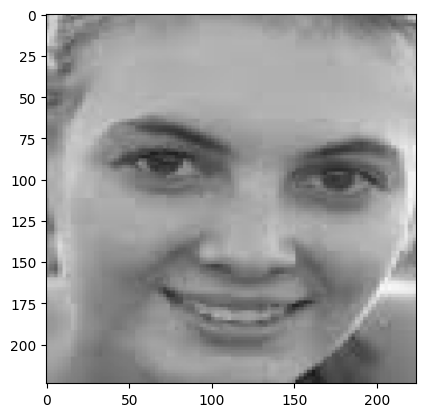

happiness: 91.95832014083862%
disgust: 3.426291048526764%
contempt: 2.8408342972397804%
neutrality: 0.9953229688107967%
anger: 0.3487084759399295%
sadness: 0.3456355072557926%
fear: 0.062399281887337565%
surprise: 0.022484314104076475%


In [4]:
# Test the model:
model_path = 'model/master/emotion_model_pytorch.pth'
predict_image(model_path, 'dataset/kaggle/happiness/images (20)_face.png')
# predict_image(model_path, 'dataset/kaggle/anger/2Q__ (2)_face.png')
# predict_image(model_path', dataset/sample/test/surprise/PublicTest_88902041.jpg')
# predict_image(model_path, 'dataset/web/happy/image-1.jpg')